## Project Object

- Camera Calibration
- Perspective Transform
- Polynomial Fit
- Curvature Radius Calculation

In [5]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import glob

### Camera Calibration Function

In [6]:
def getImgObjPts(img_dir,nx,ny):
    '''this function takes the directory of imgs, corner size nx,ny and returns the objpoints to be used in the calibrateCamera function'''
    images = glob.glob(img_dir + '*.jpg')

    objpts = []
    imgpts = []

    objp = np.zeros((nx * ny,3),np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    for image_file in images:
        img = cv2.imread(image_file)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        if ret == True:
            imgpts.append(corners)
            objpts.append(objp)

    return objpts, imgpts

def undist(img,objpts,imgpts):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, img.shape[1::-1], None, None)
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted

### Calibrate Camera and Generate Output into Folder

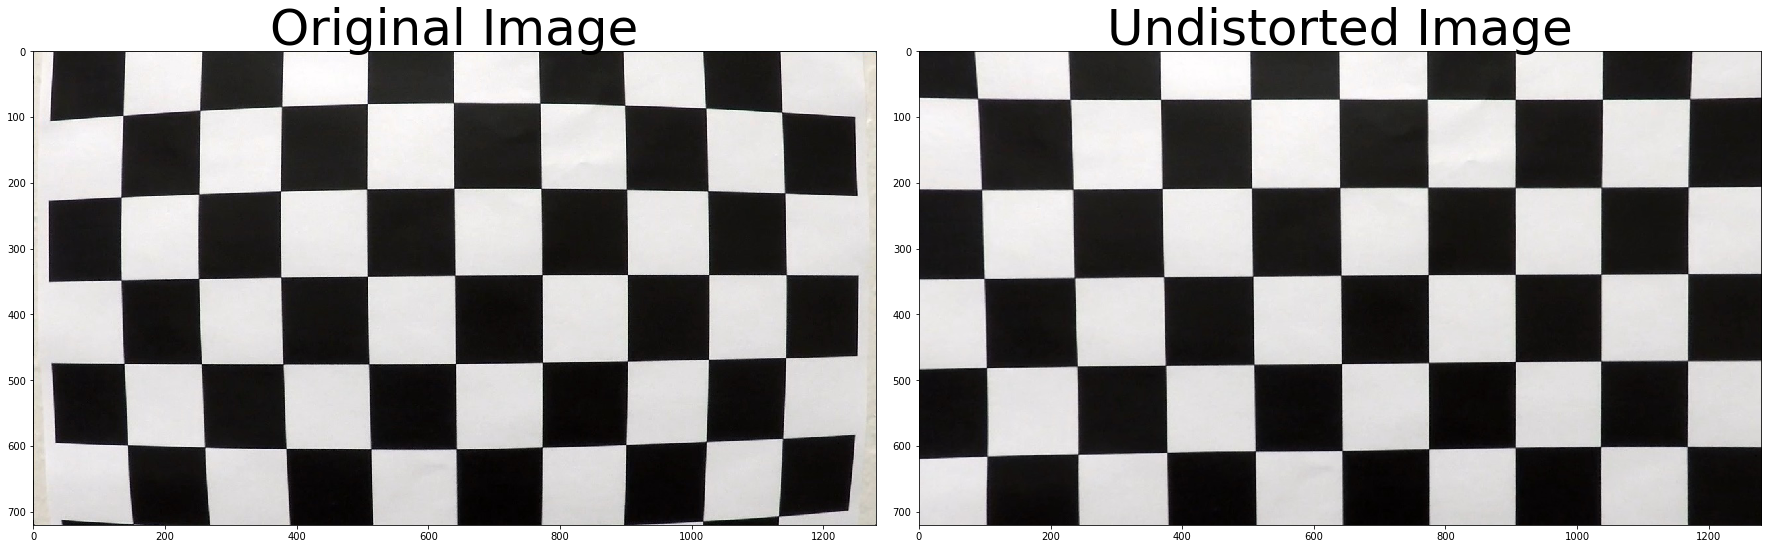

In [7]:
img_path = './camera_cal/'
out_path = './output_images/'
     
cam_x = 9
cam_y = 6

objpts, imgpts = getImgObjPts(img_path,cam_x,cam_y)

img = plt.imread(img_path + 'calibration1.jpg')

undistorted = undist(img,objpts,imgpts)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.set_title('Original Image', fontsize=50)
ax1.imshow(img)
ax2.set_title('Undistorted Image', fontsize=50)
ax2.imshow(undistorted)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig(os.path.join(out_path, 'undist.jpg'))

### Function that creates binary img based on gradient, s_channel of HLS 

In [8]:
def binary_img(img):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    # Plotting thresholded images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Stacked thresholds')
    ax1.imshow(color_binary)

    ax2.set_title('Combined S channel and gradient thresholds')
    ax2.imshow(combined_binary, cmap='gray')
    return combined_binary,f

### test and save binary image and generate output into folder

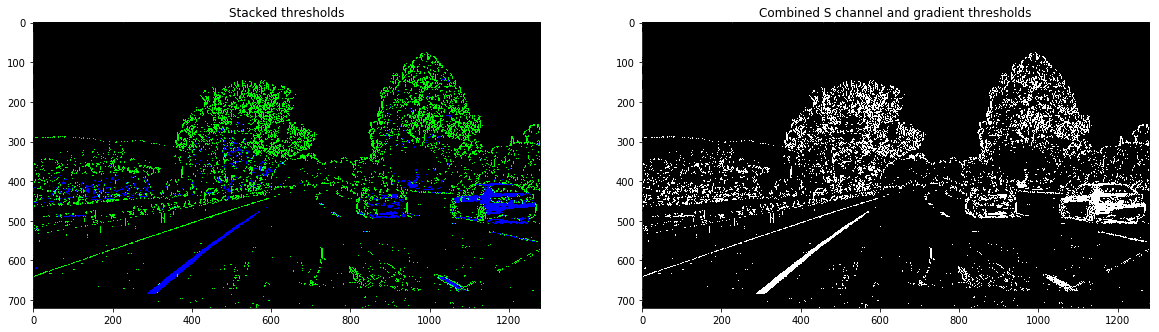

In [9]:
img = plt.imread('./test_images/test1.jpg')
binary,f = binary_img(img)
f.savefig(os.path.join(out_path, 'BinaryImg.jpg'))

### Perspective Transform

In [10]:
def Perspective_Transform(img):
    '''this function takes binary image generated from the function binary_img,
    returns the warped_img after transform, the transform matrix M and inverse of transform matrix Minv. 
    The last two will be used to recast the detect line to the original img'''
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    # 2) Convert to grayscale
#     gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    
    img_size = (img.shape[0], img.shape[1])
    # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
    
    x_center = img_size[1]/2
    x_offset=120
    src = np.float32([(x_offset,img_size[0]), (x_center-54, 450), (x_center+54, 450), (img_size[1]-x_offset,img_size[0])])
    
    x = [x_offset,x_center-54,x_center+54,img_size[1]-x_offset]
    y = [img.shape[0],450, 450,img_size[0]]
    plt.imshow(img)
    plt.plot(x, y, 'b--', lw=4)
    plt.close()
    #Note: you could pick any four of the detected corners 
    # as long as those four corners define a rectangle
    #One especially smart way to do this would be to use four well-chosen
    # corners that were automatically detected during the undistortion steps
    #We recommend using the automatic detection of corners in your code
    # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    dst = np.float32([(x_offset,img_size[1]), (x_offset,0), (img_size[0]-x_offset, 0), (img_size[0]-x_offset,img_size[1])])
    
    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped_img = cv2.warpPerspective(img, M, img_size)
    #delete the next two lines

    return warped_img, M, Minv

### Test Pespective_Transform and generate output to the folder

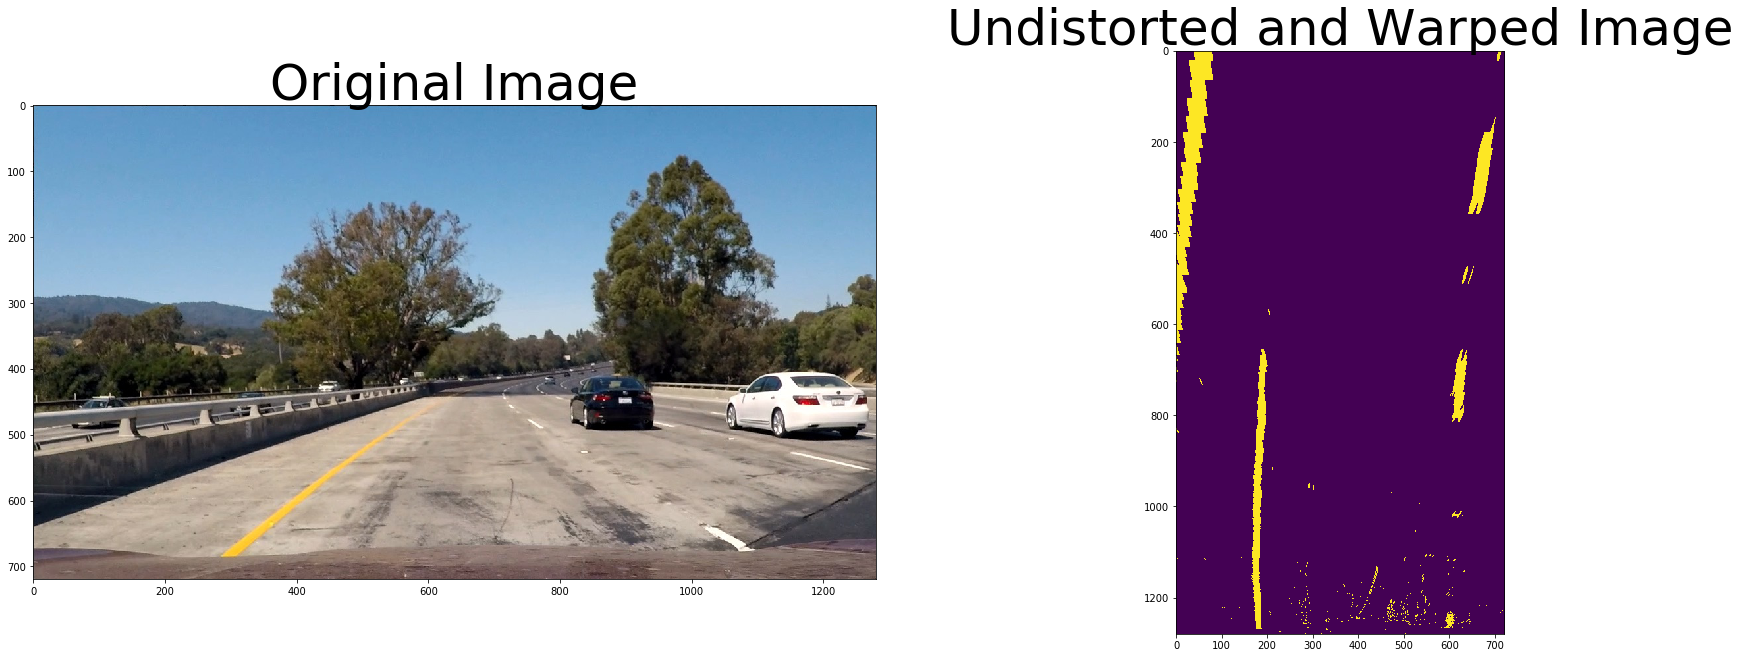

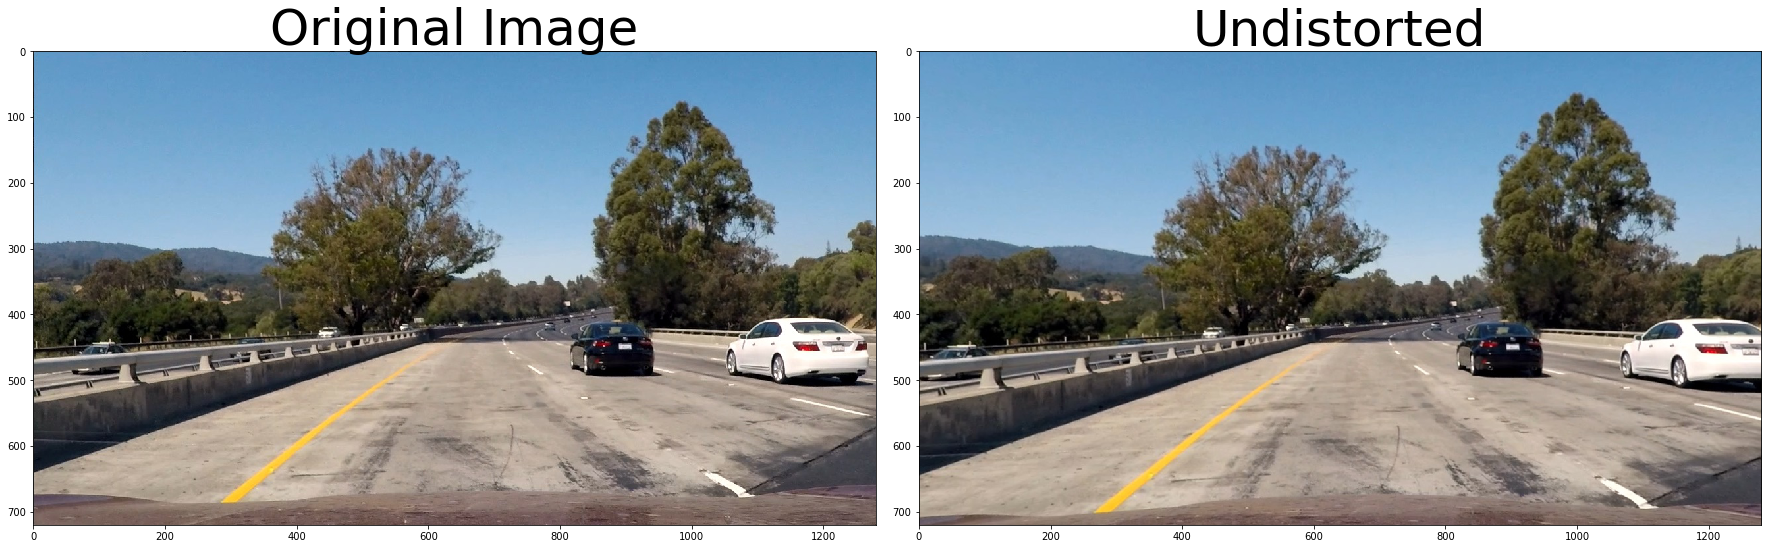

In [20]:
img_path = './camera_cal/'
out_path = './output_images/'


objpts, imgpts = getImgObjPts(img_path,cam_x,cam_y)

img = plt.imread('./test_images/test1.jpg')
undistorted= undist(img,objpts,imgpts)
binary,f1 = binary_img(undistorted)
warped, perspective_M, perspective_Minv= Perspective_Transform(binary)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig(os.path.join(out_path, 'PerspectiveTrasform.jpg'))

f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f1.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f1.savefig(os.path.join(out_path, 'Road_undist.jpg'))


### Finding Lane Pixels

In [12]:
def find_lane_pixels(binary_warped):
    '''this function take the binary_img after the perspective transform and 
    returns the pixels of left and right lane'''
    #Number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 200

    # Take a histogram of the bottom half of the image
    # Grab only the bottom half of the image: Lane lines are likely to be mostly vertical nearest to the car
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)

    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    height = binary_warped.shape[0]

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_top = height - (window+1)*window_height
        win_bottom = height - window*window_height

        win_xleft_low = leftx_current - margin     #left x value for left window
        win_xleft_high = leftx_current + margin    #right x value for left window
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_top) & (nonzeroy < win_bottom)\
                          & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_top) & (nonzeroy < win_bottom)\
                           & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    '''this function take the binary_img after the perspective transform and 
    returns the polynomial coefficients and their line points.'''
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    img_shape = binary_warped.shape
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    # Plots the left and right polynomials on the lane lines
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')

    return out_img,left_fitx,right_fitx,ploty,left_fit,right_fit

def search_around_poly(binary_warped,previous_left_fit,previous_right_fit):
    '''NOTE: this function will only be used if there exists usable previous polynomial coefficients.
    this function take the binary_img after the perspective transform, polynomial coefficients from previous step and 
    returns the polynomial coefficients and their line points.'''
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!

    # Get indices of all nonzero pixels along x and y axis
    nonzero = binary_warped.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    # Set margin for searching
    margin = 100
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
   # Compute the windows boundaries
    previous_left_x = previous_left_fit[0]*nonzeroy**2 + previous_left_fit[1]*nonzeroy + previous_left_fit[2]
    win_leftx_low = previous_left_x - margin
    win_leftx_high =  previous_left_x + margin
    previous_right_x = previous_right_fit[0]*nonzeroy**2 + previous_right_fit[1]*nonzeroy + previous_right_fit[2]
    win_rightx_low = previous_right_x - margin
    win_rightx_high =  previous_right_x + margin
    # Identify non zero pixels within left and right windows
    good_left_inds = ((nonzerox >= win_leftx_low) & (nonzerox < win_leftx_high)).nonzero()[0]
    good_right_inds = ((nonzerox >= win_rightx_low) & (nonzerox < win_rightx_high)).nonzero()[0]

    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    img_shape = binary_warped.shape
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    return out_img, left_fit, right_fit, left_lane_inds, right_lane_inds, left_fitx,right_fitx,ploty

In [13]:
# img_path = './camera_cal/'
# out_path = './output_images/'


# objpts, imgpts = getImgObjPts(img_path,cam_x,cam_y)

# img = plt.imread('./test_images/test1.jpg')
# undistorted= undist(img,objpts,imgpts)
# binary,f1 = binary_img(undistorted)
# binary_warped, perspective_M, perspective_Minv= Perspective_Transform(binary)

# out_img,left_fitx,right_fitx,ploty,left_fit,right_fit = fit_polynomial(binary_warped)

# # plt.imshow(out_img)


# # plt.savefig(os.path.join(out_path, 'lane_line_pixels.jpg'))

### Calculate Radius and Vehicle Position

In [14]:
def curvature_vehpos_real(img, ploty, left_fitx, right_fitx):
    '''This function takes the img output from the ploynomial fit function and 
    return the curvature of polynomial functions in meters, vehicle offset to lane center, and top/bottom lane width of the ROI.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    

    left_fitx_m = left_fitx * xm_per_pix
    right_fitx_m = right_fitx * xm_per_pix
    ploty_m = ploty * ym_per_pix
    
   
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty_m)
    left_fit = np.polyfit(ploty_m, left_fitx_m, 2)
    right_fit = np.polyfit(ploty_m, right_fitx_m, 2)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2 * left_fit[0] * y_eval + left_fit[1])**2)**1.5) / np.absolute(2 * left_fit[0])
    right_curverad = ((1 + (2 * right_fit[0] * y_eval + right_fit[1])**2)**1.5) / np.absolute(2 * right_fit[0])
    
    # Calculate vehicle distance to lane center
    car_center = img.shape[1]/2 * xm_per_pix  # we assume the camera is centered in the car
    lane_center = ((left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]) + (right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2])) / 2
    center_offset = lane_center - car_center
    
    # Compute lane width
    top_yvalue = 10
    bottom_yvalue = img.shape[0]
    top_leftx = left_fit[0]*top_yvalue**2 + left_fit[1]*top_yvalue + left_fit[2]
    bottom_leftx = left_fit[0]*bottom_yvalue**2 + left_fit[1]*bottom_yvalue + left_fit[2]
    top_rightx = right_fit[0]*top_yvalue**2 + right_fit[1]*top_yvalue + right_fit[2]
    bottom_rightx = right_fit[0]*bottom_yvalue**2 + right_fit[1]*bottom_yvalue + right_fit[2]
    bottom_lane_width = abs(bottom_leftx - bottom_rightx) * xm_per_pix
    top_lane_width = abs(top_leftx - top_rightx) * xm_per_pix
    
    return left_curverad,right_curverad,center_offset, top_lane_width, bottom_lane_width

### Draw Results

In [15]:
def draw_result(image,warped,left_fit,right_fit,Minv,undistorted,left_rad,right_rad,center_offset):
    '''this function takes the orignial img, warped img and draw related line area, offest and curvature radius to the original img'''
    # calculate average radius of both left and right line
    curv = (left_rad+right_rad)/2
    #calculate fitted line points
    ploty = np.linspace(0, img.shape[1]-1, img.shape[1])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    
    #add text to the figure
    text = 'Lane curvature: ' + '{:.0f}'.format(curv) + 'm'
    cv2.putText(result, text, (50, 50), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
    position = "left" if center_offset > 0 else "right"
    abs_center_offset = abs(center_offset)
    text = 'Vehicle pos: {:.2f}'.format(abs_center_offset) + 'm ' + position + ' from center'
    cv2.putText(result, text, (50, 100), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    
    return result

### Test final img output and generate output to folder

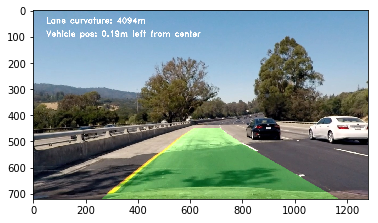

In [16]:
objpts, imgpts = getImgObjPts(img_path,cam_x,cam_y)

img = plt.imread('./test_images/test4.jpg')
undistorted= undist(img,objpts,imgpts)
binary,f1 = binary_img(undistorted)
binary_warped, M, Minv= Perspective_Transform(binary)
out_img,left_fitx,right_fitx,ploty,left_fit,right_fit = fit_polynomial(binary_warped)

left_curverad, right_curverad,center_offset,top_lane_width,bottom_lane_width = curvature_vehpos_real(out_img, ploty, left_fitx, right_fitx)
# print(left_curverad,right_curverad)
final_image=draw_result(img,binary_warped,left_fit,right_fit,Minv,undistorted,left_curverad,right_curverad,center_offset)
plt.imshow(final_image)
plt.savefig(os.path.join(out_path, 'final_img.jpg'))

In [17]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # Was the line detected in the last iteration?
        self.detected = False
        # Polynomial coefficients for the most recent fit
        self.recent_fit = []
        # Polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        # Radius of curvature of the lines
        self.radius_of_curvature = None
        # Distance in meters of vehicle center from the line
        self.center_offset = 0

    def sanity_check(self, left_fit, right_fit, left_curv_rad, right_curv_rad, top_lane_width, bottom_lane_width):
        '''check if detected lane is making sense'''
        # Check that both lines have similar curvature
        if abs(left_curv_rad - right_curv_rad) > 1500:
            return False

        # Check that both lines are separated by approximately the right distance horizontally
        lane_width = (top_lane_width + bottom_lane_width) / 2
        if abs(2.0 - lane_width) > 0.5:
            return False

        # Check that both lines are roughly parallel
        if abs(top_lane_width - bottom_lane_width) > 0.7:
            return False

        return True
    
    def update_lines(self, left_fit, right_fit, left_curv_rad, right_curv_rad, center_offset, top_lane_width, bottom_lane_width):
        '''update the line info'''
        is_detection_ok = self.sanity_check(left_fit, right_fit, left_curv_rad, right_curv_rad, top_lane_width, bottom_lane_width) == True

        # Update history with the current detection
        if (left_fit is not None and right_fit is not None and is_detection_ok):
            self.detected = True
            # Add the new lines
            self.recent_fit.append((left_fit, right_fit))
            self.radius_of_curvature = (left_curv_rad, right_curv_rad)
            self.center_offset = center_offset
            self.lane_width = (top_lane_width + bottom_lane_width) / 2
            # Update best fit
            self.best_fit = np.average(self.recent_fit, axis=0)

        # Do not take into account this failed detection
        else:
            self.detected = False
            
            
    def video_processing(self,img):
        '''main function that processes the video'''
#         #1. calibrate camera
#         objpts, imgpts = getImgObjPts(img,cam_x,cam_y)
        #1. undistort the camera input
        undistorted= undist(img,objpts,imgpts)
        #2. calculate the binary output based on several threshold criteria
        binary,_= binary_img(undistorted)
        #3. perspective transform
        binary_warped, M, Minv= Perspective_Transform(binary)
        #4. detect line
        if self.best_fit is None:  # no previous line detect, first detedction
            out_img,left_fitx,right_fitx,ploty,left_fit,right_fit = fit_polynomial(binary_warped)
        else:
            out_img, left_fit, right_fit, left_lane_inds, right_lane_inds,left_fitx,right_fitx,ploty = search_around_poly(binary_warped, self.best_fit[0], self.best_fit[1])
        
        #5. calculate radius of curve and position of vehicle
        left_curv_rad,right_curv_rad,center_offset,top_lane_width,bottom_lane_width = curvature_vehpos_real(out_img, ploty, left_fitx, right_fitx)
        #6. update line info
        self.update_lines(left_fit, right_fit, left_curv_rad, right_curv_rad, center_offset, top_lane_width, bottom_lane_width)
        #7. draw final img        
        if self.detected:  # use current lane info     
            
            result = draw_result(img,binary_warped,self.recent_fit[-1][0],self.recent_fit[-1][1],Minv,undistorted,self.radius_of_curvature[0],self.radius_of_curvature[1],self.center_offset)
        elif not self.detected and self.best_fit is not None: # no previous good detection but exists best_fit；thus use history
            result = draw_result(img,binary_warped,self.best_fit[0],best_fit[1],Minv,undistorted,left_curv_rad,right_curv_rad,center_offset)
        else:#no previous detection and no best_fit
            result = draw_result(img,binary_warped,left_fit,right_fit,Minv,undistorted,left_curv_rad,right_curv_rad,center_offset)
        
        return result
        

### Final Output of the Video

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


project_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
line = Line()
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(line.video_processing) 
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [28:19<00:01,  1.34s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 25min, sys: 24.7 s, total: 25min 25s
Wall time: 28min 22s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))